# CS 179: Final Project
## PCA Recommender System 
---
***Group Members | SID***

Erik Gomez | 38017181 <br>
Filip Velasquez | 47444867 <br>
Killian Weber | 86163603

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')  # movieId title genres
ratings = pd.read_csv('ml-latest-small/ratings.csv')  # userId movieId rating timestamp
ratings.drop(['timestamp'], axis=1, inplace=True)  # we don't care about timestap so lets get rid of it

In [3]:
# lets further process our data set by merging our tables
data = ratings.merge(movies, on='movieId', how='left')
data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


We can transform our data into a table where the rows reprsent the userId, and the columns represent the title. 
We can then fill in missing values with 0 to then compute the correlation matrix.

In [4]:
user_title = data.pivot_table(index='userId',columns='title',values='rating')
user_title = user_title.replace(np.nan, 0, regex=True)
user_title.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Let's split into training & test:
# user_title.shape : 610, 9719 (userId, title)
nUsers = user_title.shape[0]
np.random.seed(0)
msk = np.random.rand(len(user_title)) < 0.8

train = user_title[msk]
test = user_title[~msk]

We want to standardize our data so that the mean of observed values is 0 and the standard deviation is 1. We will do this using scikit-learn object StandardScalar. 

In [6]:
# converts to a range between 0 and 1
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)

With our standardized data, we can create a covariance matrix that represents the covariance between each feature in our data.

In [7]:
cov_matrix = np.cov(scaled_train)

We can then take the eigendecomposition of the covariance matrix to get the principal components.

In [8]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

Plotting the explained variance and cumulative explained variance helps us determine how many components to use.

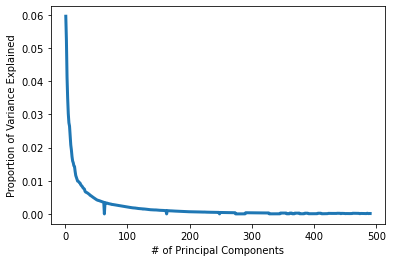

In [9]:
var_explained = []

for i in eigen_values:
    var_explained.append((i/sum(eigen_values)))


plt.plot(range(1,491), var_explained, lw=3)
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

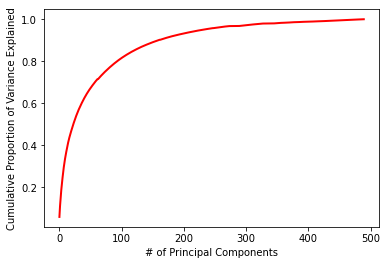

In [10]:
cum_var_explained = np.cumsum(var_explained)

plt.plot(range(490), cum_var_explained, 'r-', lw=2)
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

Apply the K components to the original standardized data where K is the number of components chosen. We chose K = 200 because it explains about 90% of the variance in the data set.

In [11]:
from scipy.linalg import svd

U, s, V = np.linalg.svd(scaled_train, full_matrices=False)

In [12]:
W = U.dot(np.diag(s))

In [13]:
X0 = W[:,:200].dot(V[:200])

In [14]:
X = scaler.inverse_transform(X0)
X

array([[ 1.39912222e-04,  7.46244764e-04, -4.17657648e-04, ...,
        -3.69322047e-04,  3.97667790e+00,  6.31904536e-05],
       [-3.97055363e-03, -1.39478956e-02, -1.34089762e-02, ...,
        -6.04741652e-04, -5.24060610e-02, -1.02790275e-04],
       [ 1.08908155e-04,  3.29420350e-04,  2.80993384e-04, ...,
        -5.11931623e-04,  1.04639134e-02, -7.45221570e-05],
       ...,
       [ 5.89896623e-05, -1.64974975e-03, -6.80425374e-04, ...,
        -4.17598027e-04,  3.25070816e-03,  8.46480469e-05],
       [-1.51057359e-03,  8.79620878e-03,  4.72737228e-03, ...,
        -3.89653946e-03, -1.70138960e-01,  1.06543575e-03],
       [ 3.99973401e+00,  3.30170747e-04,  3.43606079e-04, ...,
         1.50001496e+00,  7.20660030e-04,  2.68145467e-06]])

In [15]:
preds_df = pd.DataFrame(X, columns=user_title.columns)
preds_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,0.000140,0.000746,-0.000418,-0.001573,-0.000991,2.247904e-15,-0.018209,5.904873e-16,-0.079357,-0.002175,...,0.0,-0.003935,0.000411,0.000389,0.000043,-0.034312,-0.020480,-0.000369,3.976678,0.000063
1,-0.003971,-0.013948,-0.013409,0.001994,0.001869,-3.606911e-15,0.027226,-1.018812e-15,0.098667,0.014006,...,0.0,-0.040656,0.016588,-0.005989,0.000776,0.008335,-0.067066,-0.000605,-0.052406,-0.000103
2,0.000109,0.000329,0.000281,-0.002976,-0.002722,1.882401e-15,0.009287,8.648485e-16,0.014095,-0.000852,...,0.0,-0.008304,-0.000592,0.000286,-0.000051,-0.008909,-0.005837,-0.000512,0.010464,-0.000075
3,-0.000013,-0.003910,-0.003379,0.001337,0.000073,1.245619e-15,-0.001478,4.961309e-16,-0.009823,0.000394,...,0.0,-0.012603,0.001564,-0.000005,0.000160,0.035778,0.007147,-0.000319,-0.013537,0.000155
4,0.000178,-0.003090,-0.003312,-0.001560,-0.007238,5.367833e-15,0.008410,7.319326e-16,-0.011240,-0.013448,...,0.0,0.009898,-0.007398,-0.000022,0.000354,-0.004908,-0.027041,0.001803,-0.029104,-0.001137


In [16]:
def recommend_movies(user_id, prediction_df, movies_df, ratings_df):
    user_row = user_id - 1  # 1 based indexing
    
    # sort the predictions
    sorted_user_pred = prediction_df.iloc[user_row].sort_values(ascending=False)
    
    # we want to use the original ratings of the user
    og_user_data = ratings_df[ratings_df.userId == (user_id)]
    
    # merge with movies data frame (full data frame)
    merged_user = (og_user_data.merge(movies_df, how='left', left_on='movieId', right_on='movieId').
                   sort_values(['rating'], ascending=False))
    merged_user.drop(['genres'], axis=1, inplace=True) 
    
    # recommended movies based on predicted rating
    recs = (movies_df[~movies_df['movieId'].isin(merged_user['movieId'])])
    to_merge_with = pd.DataFrame(sorted_user_pred).reset_index()
    recs = recs.merge(to_merge_with, how='left', left_on='title', right_on='title')
    recs.drop(['genres'], axis=1, inplace=True) 
    recs.columns = ['movieId', 'title', 'prediction']
    recs.sort_values(by=['prediction'], ascending=False)
    return merged_user, recs
    

In [17]:
rated, pred_rated = recommend_movies(125, preds_df, movies, ratings)

In [18]:
rated.head()

,userId,movieId,rating,title
82,125,7008,5.0,Last Tango in Paris (Ultimo tango a Parigi) (1...
67,125,5088,5.0,"Going Places (Valseuses, Les) (1974)"
95,125,8957,5.0,Saw (2004)
28,125,1270,5.0,Back to the Future (1985)
96,125,9010,5.0,Love Me If You Dare (Jeux d'enfants) (2003)


In [19]:
pred_rated.head()

,movieId,title,prediction
0,1,Toy Story (1995),2.097690
1,3,Grumpier Old Men (1995),-0.010606
2,4,Waiting to Exhale (1995),-0.002254
3,5,Father of the Bride Part II (1995),-0.005217
4,6,Heat (1995),0.035062


Now we try it on our testing data

In [20]:
# converts to a range between 0 and 1
scaler = StandardScaler()
scaled_test = scaler.fit_transform(test)

In [21]:
cov_matrix = np.cov(scaled_test)

In [22]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

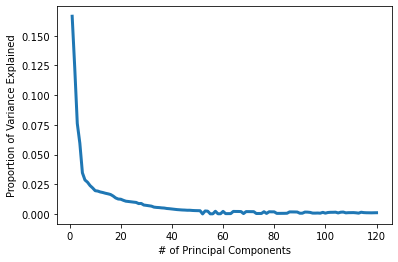

In [23]:
var_explained = []

for i in eigen_values:
    var_explained.append((i/sum(eigen_values)))


plt.plot(range(1,121), var_explained, lw=3)
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

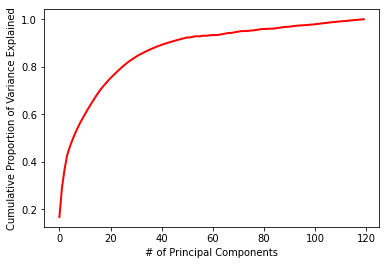

In [24]:
cum_var_explained = np.cumsum(var_explained)

plt.plot(range(120), cum_var_explained, 'r-', lw=2)
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

In [25]:
U, s, V = np.linalg.svd(scaled_train, full_matrices=False)
W = U.dot(np.diag(s))
X0 = W[:,:45].dot(V[:45])
X = scaler.inverse_transform(X0)
X

array([[-9.66686297e-02,  1.16246470e-01,  1.04522612e-01, ...,
        -2.24264299e-02,  7.55836915e-01,  1.36329691e-01],
       [-5.34601922e-02, -2.49579881e-02, -6.68144325e-02, ...,
         7.79783771e-03, -2.28627483e-02, -9.42860985e-03],
       [-1.39496642e-02, -2.77971829e-02,  2.14717710e-01, ...,
         6.32944284e-03, -4.53176190e-03,  1.61869249e-02],
       ...,
       [-7.87767634e-02,  1.79028840e-01,  1.89069767e-01, ...,
         1.69493207e-01,  5.31170801e-01, -4.36186332e-01],
       [-5.43833316e-02, -3.98104763e-02, -7.96133175e-02, ...,
         1.08878533e-03, -7.33868697e-03, -1.55035247e-02],
       [ 2.20827413e+01, -5.29173697e-02, -5.76855755e-02, ...,
         1.46843205e+00, -2.04660523e-02, -4.98570685e-02]])

In [26]:
preds_df = pd.DataFrame(X, columns=user_title.columns)
preds_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,-0.096669,0.116246,0.104523,-0.019187,-0.003570,0.0125,0.215083,0.025,0.127051,0.194075,...,0.0125,0.011990,-0.074171,-0.072915,-0.204782,0.476061,0.022513,-0.022426,0.755837,0.136330
1,-0.053460,-0.024958,-0.066814,0.016735,0.010382,0.0125,-0.008390,0.025,0.176043,0.055060,...,0.0125,0.005349,-0.055510,-0.092728,0.015225,0.081177,0.010335,0.007798,-0.022863,-0.009429
2,-0.013950,-0.027797,0.214718,0.046976,0.047104,0.0125,0.048215,0.025,0.048200,0.030814,...,0.0125,0.007643,-0.028054,-0.037238,-0.042759,0.036368,-0.003781,0.006329,-0.004532,0.016187
3,-0.033294,0.075404,-0.033286,-0.016039,0.043233,0.0125,-0.091651,0.025,0.119650,0.011620,...,0.0125,0.000390,-0.088443,-0.091439,-0.115234,0.241644,-0.078149,0.002929,0.394249,0.018691
4,-0.052444,-0.035686,-0.060005,0.014769,0.016775,0.0125,-0.031878,0.025,0.071320,0.023531,...,0.0125,0.004866,-0.054996,-0.070742,-0.067040,0.048359,-0.002319,-0.000785,-0.009391,-0.016672


In [27]:
rated, pred_rated = recommend_movies(16, preds_df, movies, ratings)

In [28]:
rated.head()

,userId,movieId,rating,title
33,16,1199,5.0,Brazil (1985)
97,16,91529,4.5,"Dark Knight Rises, The (2012)"
45,16,1252,4.5,Chinatown (1974)
77,16,4226,4.5,Memento (2000)
16,16,750,4.5,Dr. Strangelove or: How I Learned to Stop Worr...


In [29]:
pred_rated.head()

,movieId,title,prediction
0,1,Toy Story (1995),1.120254
1,2,Jumanji (1995),0.455729
2,3,Grumpier Old Men (1995),-0.015849
3,4,Waiting to Exhale (1995),-0.025699
4,5,Father of the Bride Part II (1995),0.091678
